In [9]:
!pip install vaderSentiment

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.0 MB/s eta 0:00:00


In [1]:
!pip install pyLDAvis==3.4.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 43.2 MB/s eta 0:00:00


In [11]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [17]:
!unzip mbti-personality-type-twitter-dataset.zip

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Archive:  mbti-personality-type-twitter-dataset.zip
  inflating: twitter_MBTI.csv        


In [18]:
!mv /mbti-personality-type-twitter-dataset.zip /content/

mv: cannot stat '/mbti-personality-type-twitter-dataset.zip': No such file or directory


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
!ls -l
!ls -l /content/

total 109268
-rw-r--r-- 1 root root 34241842 Nov  1 01:01 mbti-personality-type-twitter-dataset.zip
drwxr-xr-x 1 root root     4096 Oct 30 13:23 sample_data
-rw-r--r-- 1 root root 77642742 Mar 22  2023 twitter_MBTI.csv


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


total 109268
-rw-r--r-- 1 root root 34241842 Nov  1 01:01 mbti-personality-type-twitter-dataset.zip
drwxr-xr-x 1 root root     4096 Oct 30 13:23 sample_data
-rw-r--r-- 1 root root 77642742 Mar 22  2023 twitter_MBTI.csv


In [30]:
!pip install nltk gensim pyLDAvis
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import re
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Load data using the correct filename with quotes
data = pd.read_csv('/content/twitter_MBTI.csv')

# Enhanced cleaning with stop word removal and lemmatization
stop_words = set(stopwords.words('english'))

# Add Filipino stop words
filipino_stop_words = set(['ako', 'ikaw', 'siya', 'tayo', 'kayo', 'sila',
                           'ang', 'ng', 'sa', 'mga', 'ay', 'na', 'at',
                           'ni', 'para', 'kay', 'rin', 'din', 'dito',
                           'doon', 'kanya', 'kanila'])  # Add more Filipino stop words as needed
stop_words.update(filipino_stop_words)

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()  # Lowercase
    tokens = text.split()  # Tokenize
    tokens = [lemmatizer.lemmatize(token) for token in tokens
              if token not in stop_words and len(token) > 2]  # Lemmatize and remove short words
    return tokens

data['cleaned_tokens'] = data['text'].apply(clean_text)

# Create dictionary and corpus
dictionary = corpora.Dictionary(data['cleaned_tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5)  # Filter words appearing in less than 5 documents or more than 50% of documents
corpus = [dictionary.doc2bow(text) for text in data['cleaned_tokens']]

# Build LDA model with adjusted parameters
num_topics = 3  # Reduced number of topics to 3
lda_model = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        passes=15,
                        alpha=0.1,
                        eta=0.005)  # Changed eta to 0.005

# Visualize topics using pyLDAvis
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
data.rename(columns={'label': 'type'}, inplace=True)

topic_distribution = []
for index, row in data.iterrows():
    bow = dictionary.doc2bow(row['cleaned_tokens'])
    topic_probs = lda_model.get_document_topics(bow)
    topic_distribution.append({'type': row['type'], **{f'topic_{i}': prob for i, prob in topic_probs}})

topic_mbti_df = pd.DataFrame(topic_distribution).fillna(0)  # Fill missing topics with 0 probability
topic_mbti_df = topic_mbti_df.groupby('type').mean()  # Get average topic probabilities for each MBTI type

print(topic_mbti_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


       topic_1   topic_2   topic_0
type                              
enfj  0.294886  0.521791  0.182969
enfp  0.365743  0.481742  0.152154
entj  0.280705  0.596380  0.122333
entp  0.443939  0.457748  0.097822
esfj  0.360597  0.402963  0.236014
esfp  0.488827  0.335070  0.175473
estj  0.325868  0.523870  0.149954
estp  0.396067  0.441891  0.161371
infj  0.282844  0.533614  0.183022
infp  0.404849  0.419422  0.175291
intj  0.293238  0.566516  0.139683
intp  0.412848  0.441815  0.144878
isfj  0.352769  0.346205  0.300539
isfp  0.435480  0.306011  0.258172
istj  0.368451  0.428730  0.202415
istp  0.468904  0.320221  0.210533


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


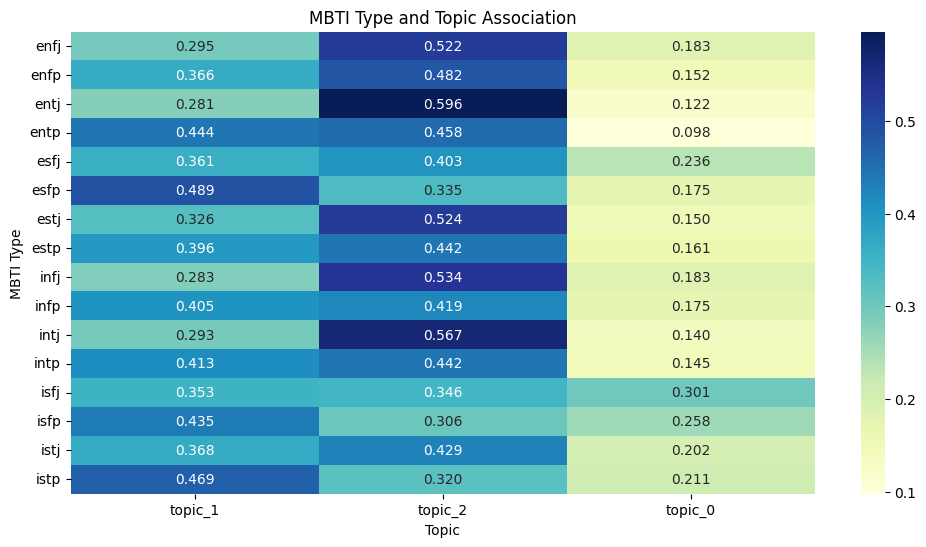

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap to visualize MBTI type and topic association
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.heatmap(topic_mbti_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("MBTI Type and Topic Association")
plt.xlabel("Topic")
plt.ylabel("MBTI Type")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


type
enfj    0.919235
enfp    0.822852
entj    0.819219
entp    0.684111
esfj    0.882078
esfp    0.755486
estj    0.714333
estp    0.753133
infj    0.815699
infp    0.778106
intj    0.749236
intp    0.745744
isfj    0.900112
isfp    0.829765
istj    0.805388
istp    0.782929
Name: sentiment, dtype: float64


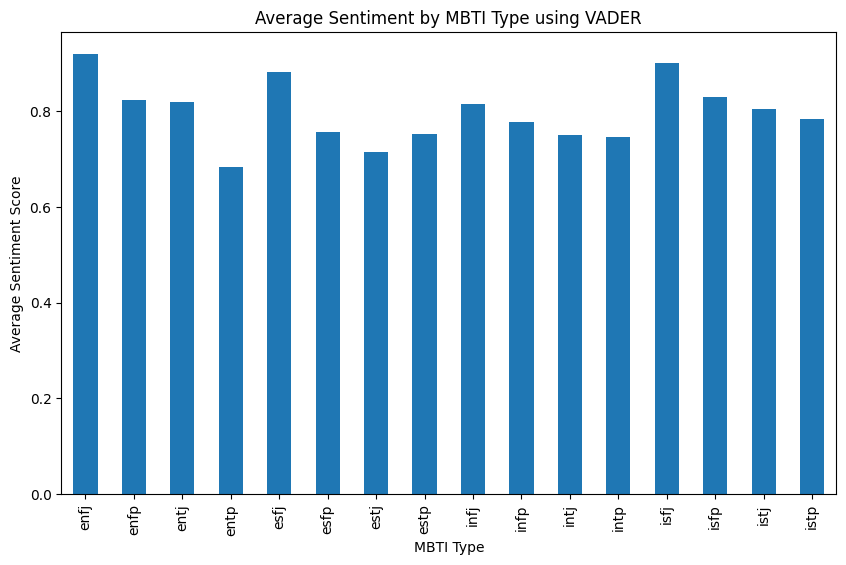

In [34]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Assuming you have a DataFrame called 'data' with 'text' column

analyzer = SentimentIntensityAnalyzer()

data['sentiment'] = data['text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

# Group by MBTI type and calculate average sentiment
sentiment_by_mbti = data.groupby('type')['sentiment'].mean()

# Print the results
print(sentiment_by_mbti)

# Visualize using a bar plot
import matplotlib.pyplot as plt
sentiment_by_mbti.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sentiment by MBTI Type using VADER')
plt.xlabel('MBTI Type')
plt.ylabel('Average Sentiment Score')
plt.show()